## Capacitated Facility Location Problem

Given the costs of connections `c_{ij}` and fixed building costs `f_i`, demands `d_j`, and capacities `u_i`, the capacitated facility location problem aims to determine which facilities to open and how to assign customers to these facilities to minimize costs while satisfying demands and not exceeding the facilities' capacities.

### Sets:
- **Facilities (I)**: Distribution Centers: DC1, DC2, DC3
- **Customers (J)**: Stores: S1, S2, S3, S4

### Parameters:
- **Opening Cost (`f_i`)**:
  - DC1: $150,000
  - DC2: $100,000
  - DC3: $180,000

- **Serving Cost (`c_{ij}`)**:

    |      | S1 | S2 | S3 | S4 | 
    |------|----|----|----|----|
    | DC1  | 50 | 60 | 70 | 85 | 
    | DC2  | 75 | 45 | 55 | 50 | 
    | DC3  | 65 | 80 | 40 | 60 | 


- **Capacities (`u_i`)**:
  - DC1: 100
  - DC2: 80
  - DC3: 90

- **Demands (`d_j`)**:
  - S1: 40
  - S2: 30
  - S3: 20
  - S4: 25

### Decision Variables:
- `y_i`: Binary decision variable, 1 if we open facility `i`, 0 otherwise.
- `x_{ij}`: Continuous decision variable representing the fraction of demand of customer `j` satisfied by facility `i`.

### Mathematical Model:
\[
\text{Minimize:} \sum_{i \in I}\sum_{j \in J}c_{ij}x_{ij}+\sum_{i \in I}f_iy_i
\]
Subject to:
1. \(\sum_{i \in I}x_{ij}=1\) for all \(j \in J\)
2. \(\sum_{j \in J}d_jx_{ij} \leq u_iy_i\) for all \(i \in I\)
3. \(x_{ij} \geq 0\) for all \(i \in I, j \in J\)
4. \(y_i \in \{0,1\}\) for all \(i \in I\)


# Load the data

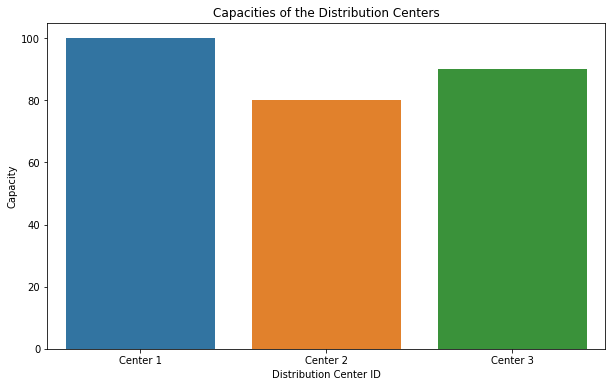

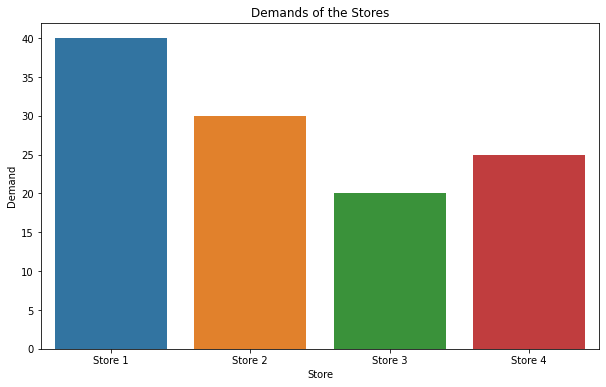

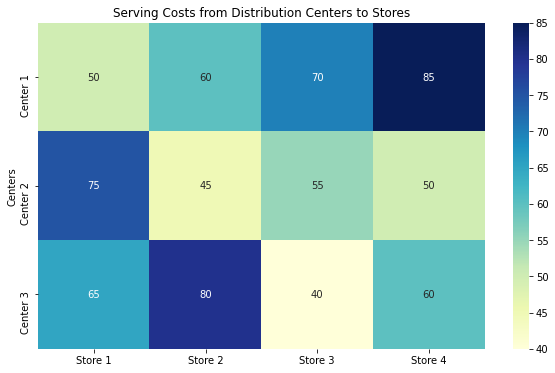

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data from Excel
df_centers = pd.read_excel('distribution_data.xlsx', sheet_name='Distribution Centers')
df_serving_costs = pd.read_excel('distribution_data.xlsx', sheet_name='Serving Costs')
df_center_capacity = pd.read_excel('distribution_data.xlsx', sheet_name='Center Capacity')
df_store_demand = pd.read_excel('distribution_data.xlsx', sheet_name='Store Demand')

centers = df_centers['Distribution Center ID'].tolist()
center_costs = df_centers['Cost'].tolist()
center_capacity = df_center_capacity['Capacity'].tolist()

stores = df_store_demand['Store'].tolist()
store_demand = df_store_demand['Demand'].tolist()

serving_costs = df_serving_costs.set_index("Centers").T.to_dict('list')


# Plotting the Capacities of the Distribution Centers
plt.figure(figsize=(10, 6))
sns.barplot(x=df_center_capacity["Distribution Center ID"], y=df_center_capacity["Capacity"])
plt.title("Capacities of the Distribution Centers")
plt.ylabel("Capacity")
plt.show()

# Plotting the Demands of the Stores
plt.figure(figsize=(10, 6))
sns.barplot(x=df_store_demand["Store"], y=df_store_demand["Demand"])
plt.title("Demands of the Stores")
plt.ylabel("Demand")
plt.show()

# Heatmap for Serving Costs
plt.figure(figsize=(10, 6))
sns.heatmap(df_serving_costs.set_index("Centers"), annot=True, cmap="YlGnBu")
plt.title("Serving Costs from Distribution Centers to Stores")
plt.show()


# Optimize

In [33]:
import pandas as pd
from gurobipy import Model, GRB

# Initialize Model
m = Model("CapacitatedFacilityLocation")

# Decision Variables
x = m.addVars(centers, stores, vtype=GRB.CONTINUOUS, name="x")
y = m.addVars(centers, vtype=GRB.BINARY, name="y")

# Objective Function
m.setObjective(sum(center_costs[i] * y[center] for i, center in enumerate(centers)) +
               sum(serving_costs[center][j] * x[center, store] for center in centers for j, store in enumerate(stores)), 
               GRB.MINIMIZE)

# Constraints
for j, store in enumerate(stores):
    m.addConstr(sum(x[center, store] for center in centers) == 1, f"StoreDemand_{store}")

for i, center in enumerate(centers):
    m.addConstr(sum(store_demand[j] * x[center, store] for j, store in enumerate(stores)) <= center_capacity[i] * y[center], f"CenterCapacity_{center}")

m.write('flc.lp')
# Solve the Model
m.optimize()

# Output the Results
for center in centers:
    if y[center].x > 0.5:
        print(f"Open {center}")
        for j, store in enumerate(stores):
            if x[center, store].x > 0:
                print(f"  Serve {store} with {x[center, store].x*store_demand[j]:.2f} units")

print(f"Total cost: ${m.objVal:.2f}")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 7 rows, 15 columns and 27 nonzeros
Model fingerprint: 0x052e691c
Variable types: 12 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e+01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 7 rows, 15 columns, 27 nonzeros
Variable types: 12 continuous, 3 integer (3 binary)
Found heuristic solution: objective 430185.00000

Root relaxation: objective 1.527031e+05, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 152703.125    0    1 430185.000 152703.125  64.5%     -    0s
H    0     0                    250203.12500 152703.125  39.0%     -    0s
     0   

# Plot the solution

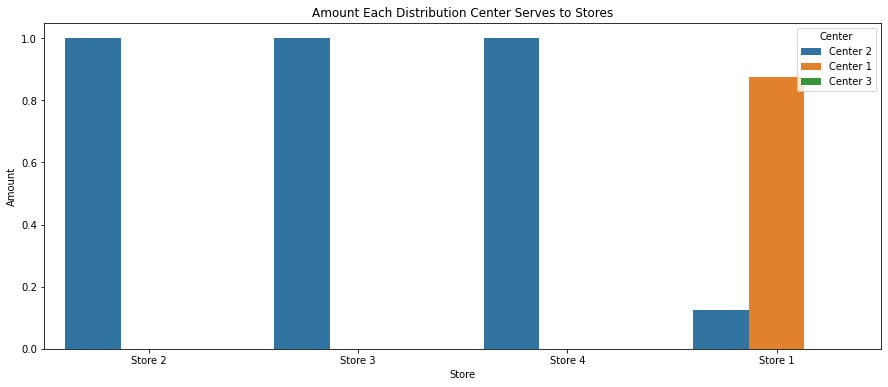

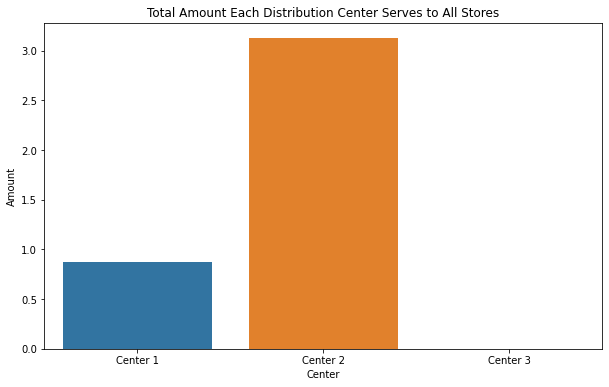

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gurobipy import Model, GRB

# ... [Load Data & Solve Model Code: Refer to the Previous Answer] ...

# Bar Chart Showcasing How Much Demand of Each Store is Satisfied by Each Distribution Center
data = {}
for center in centers:
    for store in stores:
        data[(center, store)] = x[center, store].x

df_solution = pd.DataFrame(list(data.items()), columns=["Center_Store", "Amount"]).sort_values(by="Amount", ascending=False)
df_solution[['Center', 'Store']] = df_solution['Center_Store'].apply(pd.Series)
df_solution = df_solution.drop(columns=['Center_Store'])

plt.figure(figsize=(15, 6))
sns.barplot(data=df_solution, x="Store", y="Amount", hue="Center")
plt.title("Amount Each Distribution Center Serves to Stores")
plt.ylabel("Amount")
plt.show()

# Bar Chart Showcasing the Total Amount Each Distribution Center Serves to All Stores Combined
df_total = df_solution.groupby("Center").sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_total, x="Center", y="Amount")
plt.title("Total Amount Each Distribution Center Serves to All Stores")
plt.ylabel("Amount")
plt.show()


In [ ]:
# Generating Data file

In [28]:
import pandas as pd

# Data
centers = ["Center 1", "Center 2", "Center 3"]
stores = ["Store 1", "Store 2", "Store 3", "Store 4"]

center_costs = [150000, 100000, 180000]
serving_costs = [[50, 60, 70, 85], 
                 [75, 45, 55, 50], 
                 [65, 80, 40, 60]]

center_capacity = [100, 80, 90]
store_demand = [40, 30, 20, 25]

# Create DataFrames
df_centers = pd.DataFrame({
    "Distribution Center ID": centers,
    "Cost": center_costs
})

df_serving_costs = pd.DataFrame(serving_costs, columns=stores, index=centers)
df_serving_costs.insert(0, "Centers", centers)

df_center_capacity = pd.DataFrame({
    "Distribution Center ID": centers,
    "Capacity": center_capacity
})

df_store_demand = pd.DataFrame({
    "Store": stores,
    "Demand": store_demand
})

# Write to Excel
with pd.ExcelWriter("distribution_data.xlsx") as writer:
    df_centers.to_excel(writer, sheet_name="Distribution Centers", index=False)
    df_serving_costs.to_excel(writer, sheet_name="Serving Costs", index=False)
    df_center_capacity.to_excel(writer, sheet_name="Center Capacity", index=False)
    df_store_demand.to_excel(writer, sheet_name="Store Demand", index=False)

print("Excel file 'distribution_data.xlsx' has been created!")


Excel file 'distribution_data.xlsx' has been created!
